In [1]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchinfo import summary

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchvision.io import read_image
from torchvision.io import ImageReadMode
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

plt.style.use('seaborn')
%matplotlib inline

In [2]:
seed = 42
n_channels = 1
n_classes = 5
n_epochs = 10
n_workers = 8
img_size = 28
batch_size = 32
learning_rate = 1e-3
weight_decay = 0.0
device = 'mps'
device = torch.device(device)

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    print('Seed set to', seed)
    
    
set_seed(seed)

Seed set to 42


In [4]:
transform = [
    transforms.ToTensor(),
    transforms.Resize((img_size, img_size)),
    transforms.Pad(2, fill=0),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
]

if n_channels == 1:
    transform.append(transforms.Grayscale())

transform = transforms.Compose(transform)
train_dataset = ImageFolder('./data/train/', transform=transform)
test_dataset = ImageFolder('./data/test/', transform=transform)

print('\nTrain Dataset:')
print(train_dataset)
print('\nTest Dataset:')
print(test_dataset)

train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              num_workers=n_workers,
                              shuffle=True)

test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             num_workers=n_workers,
                             shuffle=True)


Train Dataset:
Dataset ImageFolder
    Number of datapoints: 7500
    Root location: ./data/train/
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=None)
               Pad(padding=2, fill=0, padding_mode=constant)
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
               Grayscale(num_output_channels=1)
           )

Test Dataset:
Dataset ImageFolder
    Number of datapoints: 2500
    Root location: ./data/test/
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=None)
               Pad(padding=2, fill=0, padding_mode=constant)
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
               Grayscale(num_output_channels=1)
           )


In [5]:
class Net(nn.Module):
    
    def __init__(self, n_channels, n_classes):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(n_channels, 6,
                               kernel_size=5,
                               stride=1,
                               padding='valid')
        self.conv2 = nn.Conv2d(6, 16,
                               kernel_size=5,
                               stride=1,
                               padding='valid')
        self.conv3 = nn.Conv2d(16, 120,
                               kernel_size=5,
                               stride=1,
                               padding='valid')
        
        self.avgpool = nn.AvgPool2d(kernel_size=2,
                                    stride=2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(120, 84)
        self.out = nn.Linear(84, n_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.avgpool(x)
        x = F.relu(self.conv2(x))
        x = self.avgpool(x)
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        x = F.relu(self.linear1(x))
        output = self.out(x)
        return output


model = Net(n_channels, n_classes)
print(summary(model, input_size=(batch_size, n_channels, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [32, 5]                   --
├─Conv2d: 1-1                            [32, 6, 28, 28]           156
├─AvgPool2d: 1-2                         [32, 6, 14, 14]           --
├─Conv2d: 1-3                            [32, 16, 10, 10]          2,416
├─AvgPool2d: 1-4                         [32, 16, 5, 5]            --
├─Conv2d: 1-5                            [32, 120, 1, 1]           48,120
├─Flatten: 1-6                           [32, 120]                 --
├─Linear: 1-7                            [32, 84]                  10,164
├─Linear: 1-8                            [32, 5]                   425
Total params: 61,281
Trainable params: 61,281
Non-trainable params: 0
Total mult-adds (M): 13.52
Input size (MB): 0.13
Forward/backward pass size (MB): 1.67
Params size (MB): 0.25
Estimated Total Size (MB): 2.04


In [6]:
model.to(device)
writer = SummaryWriter()
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
writer.add_graph(model, images.to(device))

In [8]:
acci = []
lossi = []
train_acce = []
test_acce = []
train_losse = []
test_lossse = []

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

model.to(device)
for k in range(n_epochs):
    t0 = time.time()

    model.train()
    for i, data in enumerate(train_dataloader):
        x, y = data
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        acc = torch.sum(torch.argmax(pred, dim=1) == y) / pred.shape[0]
        lossi.append(loss.item())
        acci.append(acc.item())
        
        writer.add_scalar('Loss/train_batch', loss.item(), k * len(train_dataloader) + i)
        writer.add_scalar('Accuracy/train_batch', acc.item(), k * len(train_dataloader) + i)

        if i % 20 == 0:
            print(k, i, len(train_dataloader), loss.item(), acc.item())

    t1 = time.time()

    model.eval()
    with torch.no_grad():
        total_loss = 0.0
        total_acc = 0.0
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            
            total_loss += loss_fn(pred, y).item()
            total_acc += (torch.sum(torch.argmax(pred, dim=1) == y) / pred.shape[0]).item()

        test_loss = total_loss / len(test_dataloader)
        test_acc = total_acc / len(test_dataloader)
        test_acce.append(test_acc)
        test_lossse.append(test_loss)

        writer.add_scalar('Loss/test_epoch', test_loss, k)
        writer.add_scalar('Accuracy/test_epoch', test_acc, k)

        total_loss = 0.0
        total_acc = 0.0
        for x, y in train_dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            
            total_loss += loss_fn(pred, y).item()
            total_acc += (torch.sum(torch.argmax(pred, dim=1) == y) / pred.shape[0]).item()

        train_loss = total_loss / len(train_dataloader)
        train_acc = total_acc / len(train_dataloader)
        train_acce.append(train_acc)
        train_losse.append(train_loss)
        
        writer.add_scalar('Loss/train_epoch', train_loss, k)
        writer.add_scalar('Accuracy/train_epoch', train_acc, k)

    t2 = time.time()

    print('End of epoch', k)
    print(k, train_loss, train_acc, test_loss, test_acc, (t1-t0), (t2-t1), (t2-t0))
    print('=' * 80)
    
writer.close()

1 0 235 1.6088621616363525 0.21875
1 20 235 1.5975909233093262 0.25
1 40 235 1.554652452468872 0.21875


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1 60 235 1.6755199432373047 0.25
1 80 235 1.3784794807434082 0.59375


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1 100 235 1.6036345958709717 0.34375
1 120 235 1.5570743083953857 0.34375
1 140 235 1.4159477949142456 0.40625
1 160 235 1.5382652282714844 0.3125
1 180 235 1.5790070295333862 0.21875


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1 200 235 1.5107347965240479 0.28125
1 220 235 1.5464375019073486 0.25


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


End of epoch 1
1 1.4510636456469272 0.3663563829787234 1.4413061700289762 0.37420886075949367 50.92558002471924 94.12962484359741 145.05520486831665
2 0 235 1.4835984706878662 0.3125


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


2 20 235 1.6514079570770264 0.21875
2 40 235 1.4093855619430542 0.34375
2 60 235 1.4593267440795898 0.34375
2 80 235 1.3984946012496948 0.5
2 100 235 1.4705076217651367 0.28125


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


2 120 235 1.2471668720245361 0.53125
2 140 235 1.5995498895645142 0.1875
2 160 235 1.5285658836364746 0.21875
2 180 235 1.3550517559051514 0.46875
2 200 235 1.57191801071167 0.28125


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


2 220 235 1.2513200044631958 0.53125


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


End of epoch 2
2 1.3945030298638852 0.40070921994270164 1.4151525723783276 0.3947784810126582 50.683154344558716 93.70507168769836 144.38822603225708
3 0 235 1.475105881690979 0.3125


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3 20 235 1.4520134925842285 0.40625
3 40 235 1.4568462371826172 0.375
3 60 235 1.3968079090118408 0.3125
3 80 235 1.3901512622833252 0.34375


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3 100 235 1.2958062887191772 0.5
3 120 235 1.196225643157959 0.46875
3 140 235 1.4250704050064087 0.375
3 160 235 1.4696608781814575 0.40625
3 180 235 1.2591471672058105 0.5


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3 200 235 1.4766291379928589 0.25
3 220 235 1.2411081790924072 0.53125


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


End of epoch 3
3 1.3344753488581231 0.43617021276595747 1.3663970118836513 0.4165348101265823 50.2922089099884 93.4945240020752 143.7867329120636
4 0 235 1.557319164276123 0.21875
4 20 235 1.2810617685317993 0.46875


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


4 40 235 1.2545642852783203 0.40625
4 60 235 1.3543576002120972 0.3125
4 80 235 1.2147656679153442 0.53125
4 100 235 1.4332480430603027 0.40625
4 120 235 1.2821862697601318 0.4375
4 140 235 1.3434799909591675 0.5
4 160 235 1.2130447626113892 0.4375
4 180 235 1.5177083015441895 0.3125
4 200 235 1.26039719581604 0.625
4 220 235 1.2959396839141846 0.53125


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


End of epoch 4
4 1.2969042504087407 0.46325354626838194 1.3289660713340663 0.43710443037974683 50.792824029922485 93.47622895240784 144.26905298233032
5 0 235 1.5087043046951294 0.28125
5 20 235 1.3242359161376953 0.40625
5 40 235 1.3153811693191528 0.46875
5 60 235 1.2290984392166138 0.5
5 80 235 1.0753551721572876 0.53125
5 100 235 1.2942155599594116 0.5
5 120 235 1.4946155548095703 0.4375


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


5 140 235 1.0987224578857422 0.625


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


5 160 235 1.2027183771133423 0.46875
5 180 235 1.3504664897918701 0.375


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


5 200 235 1.1051578521728516 0.53125
5 220 235 1.4057762622833252 0.375


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


End of epoch 5
5 1.2733355613465005 0.4720301420130628 1.4224877417842043 0.3852848101265823 51.11096978187561 94.22032928466797 145.33129906654358
6 0 235 1.2701067924499512 0.40625
6 20 235 1.2081804275512695 0.40625


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


6 40 235 1.3408944606781006 0.40625
6 60 235 1.1560288667678833 0.5625
6 80 235 1.134291648864746 0.53125
6 100 235 1.2182624340057373 0.5


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


6 120 235 1.2260870933532715 0.53125
6 140 235 1.137643814086914 0.5
6 160 235 1.294364333152771 0.40625
6 180 235 1.1358318328857422 0.59375
6 200 235 1.2166345119476318 0.40625
6 220 235 1.1713470220565796 0.53125


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


End of epoch 6
6 1.188610600156987 0.525 1.2839230321630646 0.46875 50.47986602783203 93.72227478027344 144.20214080810547
7 0 235 1.3284382820129395 0.5
7 20 235 1.2720774412155151 0.5
7 40 235 1.4293339252471924 0.40625
7 60 235 1.3249940872192383 0.34375


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


7 80 235 1.2448927164077759 0.5625


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


7 100 235 1.3051211833953857 0.5
7 120 235 1.0926824808120728 0.625
7 140 235 1.1018078327178955 0.59375
7 160 235 1.155898094177246 0.5


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


7 180 235 1.111945629119873 0.5625
7 200 235 1.3760814666748047 0.375
7 220 235 1.146376609802246 0.46875


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


End of epoch 7
7 1.1297348336970552 0.5549202127659575 1.297592446773867 0.46281645569620256 50.318828105926514 92.87141990661621 143.19024801254272


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


8 0 235 1.2207427024841309 0.46875
8 20 235 1.0825386047363281 0.625
8 40 235 1.2063502073287964 0.53125
8 60 235 1.2210372686386108 0.5625
8 80 235 1.2684605121612549 0.5


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


8 100 235 1.1475856304168701 0.4375
8 120 235 0.9970815777778625 0.65625
8 140 235 1.1505590677261353 0.5625
8 160 235 1.2777116298675537 0.59375
8 180 235 1.2321419715881348 0.46875
8 200 235 1.1378200054168701 0.53125
8 220 235 1.118043303489685 0.5625


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


End of epoch 8
8 1.1005908562781963 0.5661790781832756 1.3071345543559594 0.48457278481012656 50.86714792251587 92.88844513893127 143.75559306144714
9 0 235 0.9773151278495789 0.6875


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


9 20 235 1.2992546558380127 0.53125
9 40 235 1.296380877494812 0.59375
9 60 235 0.9928823709487915 0.5
9 80 235 1.0685203075408936 0.59375
9 100 235 1.3733885288238525 0.34375


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


9 120 235 1.0493236780166626 0.59375
9 140 235 0.9727554321289062 0.5625
9 160 235 1.2725059986114502 0.46875
9 180 235 1.1488224267959595 0.5
9 200 235 1.131761908531189 0.46875
9 220 235 1.392655611038208 0.53125


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


End of epoch 9
9 1.035398144163984 0.6053634752618505 1.3001561979704266 0.46162974683544306 51.32210898399353 94.08019614219666 145.40230512619019
10 0 235 0.8735284805297852 0.59375
10 20 235 1.0984665155410767 0.4375


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


10 40 235 1.1480857133865356 0.625
10 60 235 1.0582164525985718 0.59375
10 80 235 1.2642431259155273 0.5
10 100 235 0.9688525199890137 0.65625
10 120 235 1.164566159248352 0.59375


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


10 140 235 1.5004035234451294 0.375
10 160 235 1.2659035921096802 0.53125
10 180 235 0.9747719764709473 0.625
10 200 235 1.0555856227874756 0.625
10 220 235 1.105223536491394 0.59375


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


End of epoch 10
10 0.961135574097329 0.6375443263256804 1.3017140204393411 0.4821993670886076 51.013418197631836 92.91980195045471 143.93322014808655


NameError: name 'write' is not defined

In [9]:
writer.close()

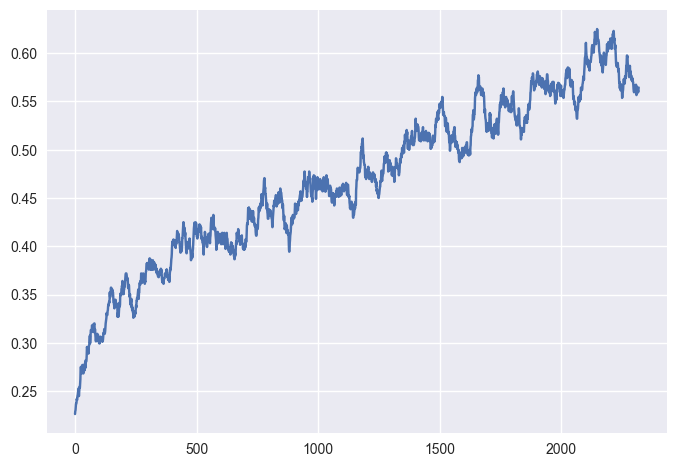

In [10]:
plt.plot(F.avg_pool1d(torch.tensor([acci]), kernel_size=batch_size, stride=1).view(-1,));

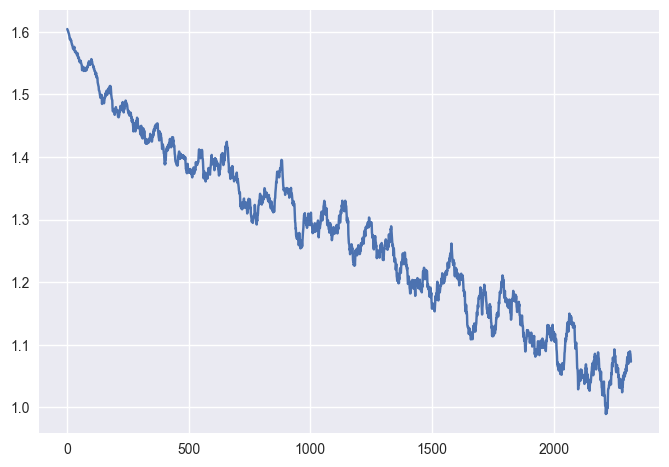

In [11]:
plt.plot(F.avg_pool1d(torch.tensor([lossi]), kernel_size=batch_size, stride=1).view(-1,));

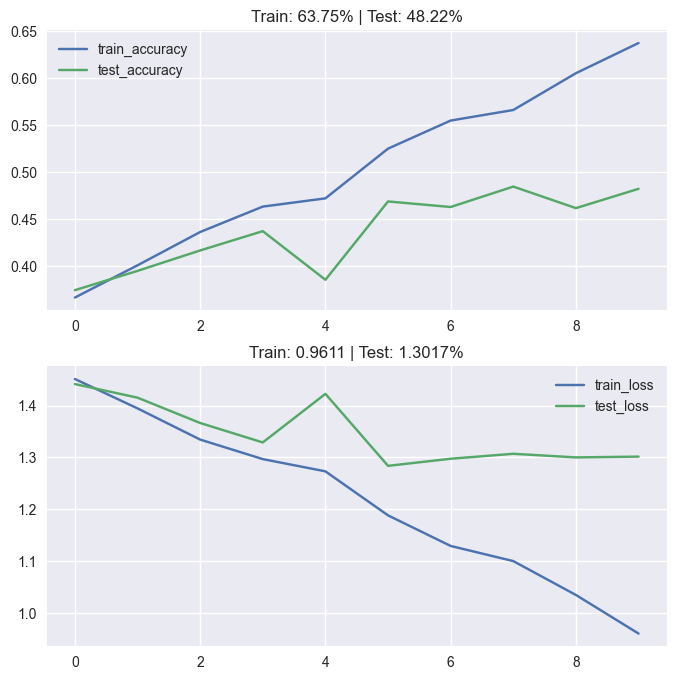

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(211)
plt.plot(train_acce, label='train_accuracy')
plt.plot(test_acce, label='test_accuracy')
plt.title(f'Train: {train_acce[-1]*100:.2f}% | Test: {test_acce[-1]*100:.2f}%')
plt.legend()
plt.subplot(212)
plt.plot(train_losse, label='train_loss')
plt.plot(test_lossse, label='test_loss')
plt.title(f'Train: {train_losse[-1]:.4f} | Test: {test_lossse[-1]:.4f}%')
plt.legend()
plt.show();

In [19]:
torch.save(model, 'model.pt')
torch.save(model.state_dict(), 'weights.pt')

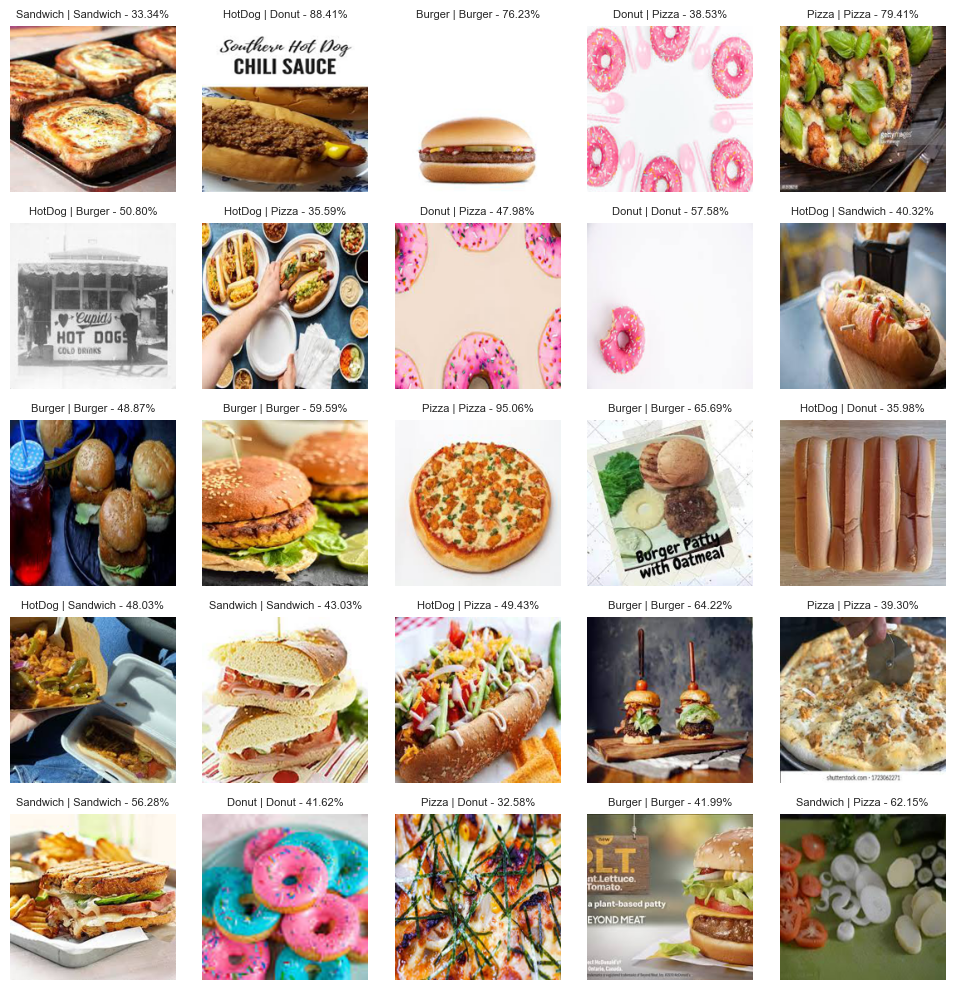

In [20]:
random_dataset = random.sample(test_dataset.imgs, 25)
idx_to_class = {v:k for k, v in test_dataset.class_to_idx.items()}
data = []

with torch.no_grad():
    model.eval()
    for x, y in random_dataset:
        img = Image.open(x)
        img_t = transform(img).to(device)
        img_t = torch.unsqueeze(img_t, dim=0)
        pred = model(img_t)
        probs = F.softmax(pred, dim=1)
        pred_idx = torch.argmax(pred, dim=1).item()
        pred_class = idx_to_class[pred_idx]
        y_class = idx_to_class[y]
        data.append((x, pred_class, probs[0][pred_idx].item(), y_class))

nrows = int(25**0.5)
plt.figure(figsize=(10, 10))
for i in range(1, 25 + 1):
    plt.subplot(nrows, nrows, i)
    img = Image.open(data[i-1][0])
    img = img.resize((200, 200))
    plt.title(f'{data[i-1][3]} | {data[i-1][1]} - {data[i-1][2]*100:.2f}%', size=8)
    plt.imshow(img)
    plt.grid()
    plt.axis('off')
    plt.tight_layout();